### Path to your dataset root directory

In [1]:
dataset_root_dir = '../data/TF'

## 1. Preprocess data and run training using Training NIM
- Call function to preprocess data
- Train models using Training NIM
  - - For local testing, deploy Training NIM
  - - Train model based on input config file

In [19]:
# Preprocess
# For local testing, deploy Training NIM
# Run training on Training NIM

## 2. Serve your model on Triton Inference Server

In [3]:
import os
import time

import tritonclient.grpc as triton_grpc
import tritonclient.http as httpclient
from tritonclient import utils as triton_utils

In [4]:
# Set to False for remote/cloud deployment
run_locally = True 

##### Replace HOST with the actual server URL where your Triton Inference Server is hosted.


In [5]:
if run_locally:
    HOST = 'localhost'
else:
    HOST = '<SERVER_URL>' # Replace with your server URL or IP address

HTTP_PORT = 8000
GRPC_PORT = 8001

### If you are testing a local deployment
- Pull Triton inference server docker image
- Deploy server with  models and configuration files (produced by the training NIM)
- Double check that your model repository folder has the following structures
```sh
├── model
│   ├── 1
│   │   └── graph_sage_node_embedder.onnx
│   └── config.pbtxt
└── xgboost
    ├── 1
    │   └── xgboost_on_embeddings.json
    └── config.pbtxt
```

In [6]:
if run_locally:
    
    # Triton server image
    TRITON_IMAGE = 'nvcr.io/nvidia/tritonserver:25.01-py3'

    # Change this path to point to the model repository folder 
    MODEL_REPO_PATH = '/home/mnaim/Triton/morpheus-experimental/ai-credit-fraud-workflow/data/TabFormer/trained_models/model_repository'

    # Pull docker 
    !docker pull {TRITON_IMAGE}
    !docker stop tritonserver
    !docker rm tritonserver

    !docker run --gpus all -d -p {HTTP_PORT}:{HTTP_PORT} -p {GRPC_PORT}:{GRPC_PORT} -v {MODEL_REPO_PATH}:/models --name tritonserver {TRITON_IMAGE} tritonserver --model-repository=/models



25.01-py3: Pulling from nvidia/tritonserver
Digest: sha256:eea017611e2231da3a06d1cf47b73efdfe4811a313001cb12f4efe13b1418134
Status: Image is up to date for nvcr.io/nvidia/tritonserver:25.01-py3
nvcr.io/nvidia/tritonserver:25.01-py3
tritonserver
tritonserver
2b05c6a8cda7c2accae64753b9a8167e1ffb3097b465733ce9c0ce9ad61b5225


### URLs for GRPC and HTTP request to the inference server

In [7]:
client_grpc = triton_grpc.InferenceServerClient(url=f'{HOST}:{GRPC_PORT}')
client_http = httpclient.InferenceServerClient(url=f'{HOST}:{HTTP_PORT}')

### Wait for the triton inference server to come online

In [8]:

TIMEOUT = 60
client_grpc = triton_grpc.InferenceServerClient(url=f'{HOST}:{GRPC_PORT}')
server_start = time.time()
while True:
    try:
        if client_grpc.is_server_ready() or time.time() - server_start > TIMEOUT:
            break
    except triton_utils.InferenceServerException:
        pass
    time.sleep(1)


### For local deployment, check if the triton inference server is running properly

In [9]:
if run_locally:
    !docker logs tritonserver



== Triton Inference Server ==

NVIDIA Release 25.01 (build 136230209)
Triton Server Version 2.54.0

Copyright (c) 2018-2024, NVIDIA CORPORATION & AFFILIATES.  All rights reserved.

Various files include modifications (c) NVIDIA CORPORATION & AFFILIATES.  All rights reserved.

This container image and its contents are governed by the NVIDIA Deep Learning Container License.
By pulling and using the container, you accept the terms and conditions of this license:
https://developer.nvidia.com/ngc/nvidia-deep-learning-container-license

NOTE: CUDA Forward Compatibility mode ENABLED.
  Using CUDA 12.8 driver version 570.86.10 with kernel driver version 565.57.01.
  See https://docs.nvidia.com/deploy/cuda-compatibility/ for details.

I0206 00:45:43.938729 1 pinned_memory_manager.cc:277] "Pinned memory pool is created at '0x7fec4e000000' with size 268435456"
I0206 00:45:43.947094 1 cuda_memory_manager.cc:107] "CUDA memory pool is created on device 0 with size 67108864"
I0206 00:45:43.947101 1 

### Read preprocessed input transactions to make query to the triton inference server

In [10]:
import pandas as pd
import numpy as np

test_path = os.path.join(dataset_root_dir, "xgb/test.csv") # already preprocessed data
test_df = pd.read_csv(test_path)
X = test_df.iloc[:, :-1].values.astype(np.float32)
y = test_df.iloc[:, -1].values
edge_index = np.array([[], []]).astype(np.int64) # empty edge_index

### Setup the HTTP request's inputs and output to retrieve embeddings for the input transactions

In [11]:
inputs_features = httpclient.InferInput("x", X.shape, datatype="FP32")
inputs_features.set_data_from_numpy(X)

inputs_edges = httpclient.InferInput("edge_index", edge_index.shape, datatype="INT64")
inputs_edges.set_data_from_numpy(edge_index)

outputs = httpclient.InferRequestedOutput("output")

### Send a query to retrieve embeddings

In [12]:
# Querying the server
results = client_http.infer(model_name="model", inputs=[inputs_features, inputs_edges], outputs=[outputs])
node_embeddings = results.as_numpy('output')
# print(node_embeddings)


### Use the retrieved embeddings as inputs to predict the transactions' fraud scores

In [13]:
inputs_xgboost = httpclient.InferInput("input__0", node_embeddings.shape, datatype="FP32")
inputs_xgboost.set_data_from_numpy(node_embeddings)

outputs_xgboost = httpclient.InferRequestedOutput("output__0")

### Send a query to retrieve the fraud scores

In [14]:
results = client_http.infer(model_name="xgboost", inputs=[inputs_xgboost], outputs=[outputs_xgboost])
predictions = results.as_numpy('output__0')

### Evaluate performance

In [15]:
from cuml.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = (predictions > 0.6).astype(int)


# Compute evaluation metrics
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred, zero_division=0)
recall = recall_score(y, y_pred, zero_division=0)
f1 = f1_score(y, y_pred, zero_division=0)

print("----Summary---")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


----Summary---
Accuracy: 0.9473
Precision: 0.8430
Recall: 0.4193
F1 Score: 0.5600


### Compute confusion matrix 

In [16]:
import pandas as pd
# Create a DataFrame with labeled rows and columns
classes = ['Non-Fraud', 'Fraud']
columns = pd.MultiIndex.from_product([["Predicted"], classes])
index = pd.MultiIndex.from_product([["Actual"], classes])

conf_mat = confusion_matrix(y, y_pred)
cm_df = pd.DataFrame(conf_mat.get(), index=index, columns=columns)
print(cm_df)

                 Predicted      
                 Non-Fraud Fraud
Actual Non-Fraud     23857   163
       Fraud          1212   875


### Plot confusion matrix

In [17]:
!pip install seaborn

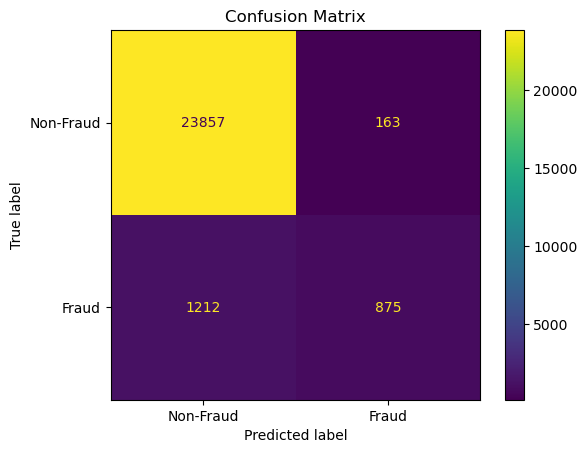

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Plot the confusion matrix directly from predictions
disp = ConfusionMatrixDisplay.from_predictions(
    y, y_pred, display_labels=classes)
disp.ax_.set_title('Confusion Matrix')
plt.show()